# Stack Overflow Tag Predictor

## Business Problem

### Description:

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.

Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.

### Problem Statement:

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

### Source: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

### Real World / Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

### Data Overview:

All of the data is in 2 files: Train and Test.

Train.csv contains 4 columns: Id,Title,Body,Tags.

Test.csv contains the same columns but without the Tags, which you are to predict.

Size of Train.csv - 6.75GB

Size of Test.csv - 2GB

Number of rows in Train.csv = 6034195

P.S:There are two files: Train.csv & Test.csv. Based on the computing power of my system, I have taken only a subset of data from Train.csv

### Data Field Explanation:

Dataset contains 6,034,195 rows. The columns in the table are:

Id - Unique identifier for each question

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')



### Type of Machine Learning Problem:

**Multi-label Classification:** Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. 

__Credit__: http://scikit-learn.org/stable/modules/multiclass.html

### Performance Metric:

1. Micro f1 score
2. Macro f1 score
3. Hamming loss

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import pickle
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable

**Util functions:**

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

In [3]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [4]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [5]:
def save_pickle(filename, matrix):
    with open(filename, 'wb') as outfile:
        pickle.dump(matrix, outfile, pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(filename, 'rb') as infile:
        matrix = pickle.load(infile)    
    return matrix

## Load Data 

In [7]:
if not os.path.isfile('Train/train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///Train/train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        #print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:53.236207


***Counting the number of rows***

In [9]:
if os.path.isfile('Train/train.db'):
    start = datetime.now()
    con = sqlite3.connect('Train/train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:04.322324


***Checking for duplicates***

In [11]:
if os.path.isfile('Train/train.db'):
    start = datetime.now()
    con = sqlite3.connect('Train/train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:11:48.386844


In [19]:
df_no_dup.shape

(4206315, 4)

**Observation:** 

- We can observe that there are duplicates from difference in number of elements in both dataframes

In [14]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [15]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

***Lets see if there are any null values and fill them with ''***

In [21]:
nan_rows = df_no_dup[df_no_dup.isnull().any(1)]
print (nan_rows)

                                                     Title  \
777547                             Do we really need NULL?   
962680   Find all values that are not null and not in a...   
1126558                                 Handle NullObjects   
1256102                           How do Germans call null   
2430668  Page cannot be null. Please ensure that this o...   
3329908       What is the difference between NULL and "0"?   
3551595         a bit of difference between null and space   

                                                      Body  Tags  cnt_dup  
777547   <blockquote>\n  <p><strong>Possible Duplicate:...  None        1  
962680   <p>I am running into a problem which results i...  None        1  
1126558  <p>I have done quite a bit of research on best...  None        1  
1256102  <p>In german null means 0, so how do they call...  None        1  
2430668  <p>I get this error when i remove dynamically ...  None        1  
3329908  <p>What is the difference from NULL an

In [22]:
# Filling the null values with ' '
df_no_dup = df_no_dup.fillna('')
nan_rows = df_no_dup[df_no_dup.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [Title, Body, Tags, cnt_dup]
Index: []


***Now lets add a new feature number of tags per question***

In [23]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:05.373403


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [ ]:
#Creating a new database with no duplicates
if not os.path.isfile('Train/train_no_dup.db'):
    disk_dup = create_engine("sqlite:///Train/train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [26]:
if os.path.isfile('Train/train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('Train/train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train_no_dup.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:40.267819


## Exploratory Data Analysis:

## Analysis of Tags 

**Total number of unique tags**

In [27]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [28]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [29]:
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


**Number of times a tag appeared**

In [30]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [47]:
tag_df = pd.DataFrame(list(result.items()), columns=['Tags', 'Counts'])

In [49]:
if not os.path.isfile('Train/tag_df.pkl'):
    save_pickle('Train/tag_df.pkl',tag_df)
tag_df = load_pickle('Train/tag_df.pkl')

***Lets sort by Tag count***

In [32]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

***Since there are lot of tags, let's check the top 100 tags by count***

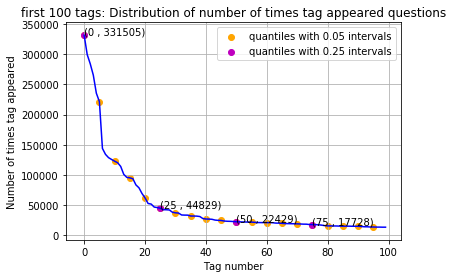

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [45]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate("({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

**Observation:**

- Top most Tag appears 331505 times.
- 20th tag appears 13703 times.

In [34]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />

1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

**Tags Per Question**

In [35]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [36]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


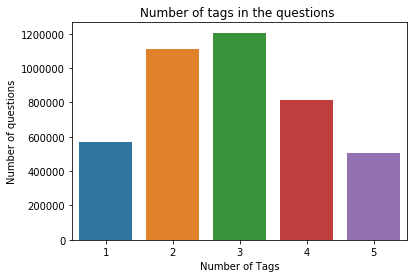

In [46]:
sns.countplot(tag_quest_count)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

**Observations:**

1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags
5. 4 tags are used intermediately.

**Most Frequent Tags**

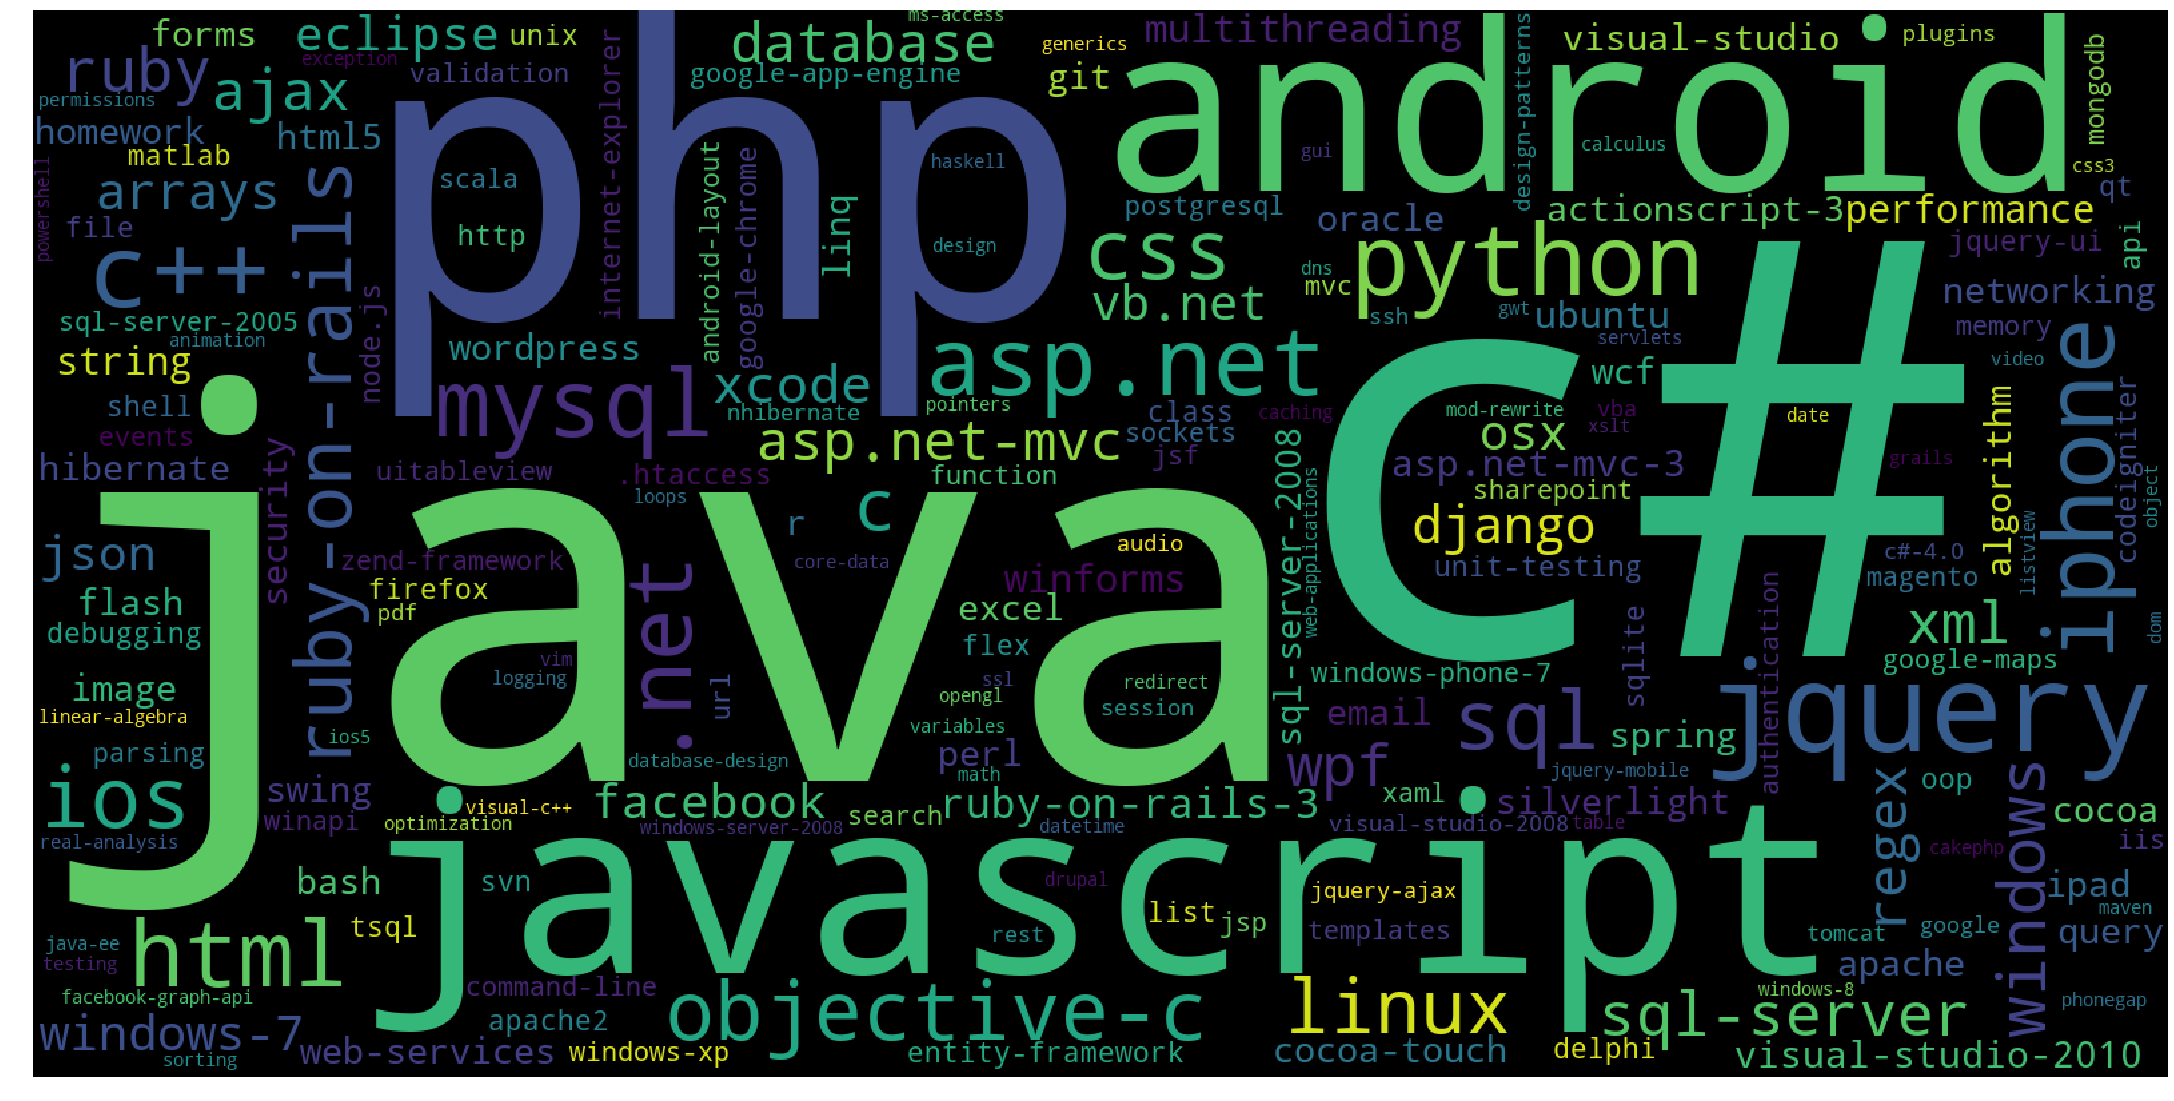

In [50]:
# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

**Observations:**

- A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.
- c# is the most used tag, followed by java which can be seen from the size in wordcloud. However let's list the top 20 tags by frequency below.

**Top 20 tags**

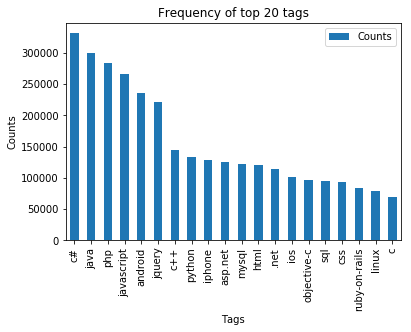

In [39]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

**Observations:**

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

***Since C# is the most frequent tag, let's see the tag count for questions where c# appears***

In [86]:
temp = pd.DataFrame(df_no_dup["tag_count"], columns=['tag_count'])
temp["cPresent"] = df_no_dup["Tags"].apply(lambda text: 1 if ("c#" in text.split(" ")) else 0)
df_filtered = temp[temp['cPresent'] == 1]
df_filtered["tag_count"].value_counts()

3    103177
4     85196
2     66185
5     60629
1     16318
Name: tag_count, dtype: int64

***Total count is 331505 which is same as the tag count for most frequent tag obtained previously.***

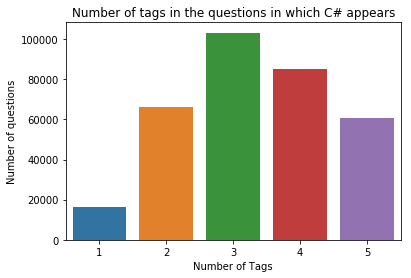

In [84]:
sns.countplot(df_filtered["tag_count"])
plt.title("Number of tags in the questions in which C# appears")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

**Observation:**

- If C# appears in a tag, then there are 103177 tags which have 2 more tags making it a 3 tag question.
- C# alone appears as a tag in 16318 questions.
- C# appears in pairs with questions having 3 tags the most, followed by 4 tag question and so on as seen from the above plot.

##  Modeling with less data points (0.1M data points) and more weight to title and 500 tags only

**Note: After trying for BoW upto 4 grams with complete data system hanged with out of memory error. Hence using top 100K data from *train_no_dup.db***

**Also giving more weight to title since largely title determines the tag in a question.**

## Pre-Processing: 

In [17]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [18]:
read_db = 'data/train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 80000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.1M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 100001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [19]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and stopwords from question except for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%20000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 20000
number of questions completed= 40000
number of questions completed= 60000
number of questions completed= 80000
number of questions completed= 100000
Avg. length of questions(Title+Body) before processing: 1232
Avg. length of questions(Title+Body) after processing: 441
Percent of questions containing code: 57
Time taken to run this cell : 0:04:03.807731


In [20]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [21]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

In [26]:
#Taking 0.1 Million entries to a dataframe & save to pickle
read_db = 'Titlemoreweight.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        loaded_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

if not os.path.isfile('preprocessed_title_more_weight.pkl'):
    save_pickle('preprocessed_title_more_weight.pkl',loaded_data)

In [8]:
preprocessed_data = load_pickle('preprocessed_title_more_weight.pkl')
preprocessed_data.shape

(100000, 2)

In [9]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [10]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


In [11]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [12]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

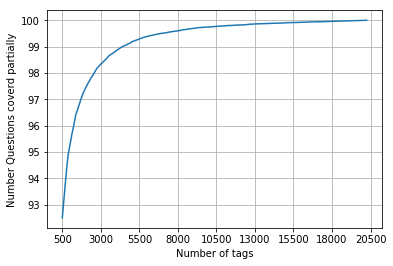

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [13]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [14]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 7500 out of  100000


In [15]:
train_datasize = 80000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [16]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


## Models:

## Bag of Words

In [17]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00001,max_features=200000, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:39.162156


In [18]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 200000) Y : (80000, 500)
Dimensions of test data X: (20000, 200000) Y: (20000, 500)


### Applying Logistic Regression with OneVsRest Classifier

**Using LogisticRegression:** First let's try with LogisticRegression.

In [37]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', C=1))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 2:12:04.866069


In [26]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.17475
Hamming loss  0.0033324
Micro-average quality numbers
Precision: 0.5922, Recall: 0.3556, F1-measure: 0.4443
Macro-average quality numbers
Precision: 0.4309, Recall: 0.2848, F1-measure: 0.3297


- Micro F1-measure: 0.4443
- Macro  F1-measure: 0.3297

**We have got good scores using Logistic Regression. However since it takes a lot of time to train a single model, train time for a hypertuned model will be a lot. So let's go with SGDClassifier with Log loss which is Logistic Regression**

In [39]:
joblib.dump(classifier, 'bow_LogisticReg_with_more_title_weight.pkl')

['bow_LogisticReg_with_more_title_weight.pkl']

**Using SGDClassifier with Log Loss:** First let's train a simple model.

In [41]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:51.892945


In [28]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.07955
Hamming loss  0.0063783
Micro-average quality numbers
Precision: 0.2704, Recall: 0.4135, F1-measure: 0.3270
Macro-average quality numbers
Precision: 0.2172, Recall: 0.3402, F1-measure: 0.2438


- Micro F1-measure: 0.3270
- Macro  F1-measure: 0.2438

**Micro & Macro F1 scores are lower than Logistic Regression model. Let's try tuning a with tolerance before we go for Hyper param tuning**

In [46]:
joblib.dump(classifier, 'bow_lr_with_more_title_weight.pkl')

['bow_lr_with_more_title_weight.pkl']

**Using SGDClassifier with Log Loss with max_iter=1000, tol=0.0001**

In [40]:
#With max_iter=1000, tol=0.0001
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', max_iter=1000, tol=0.0001))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 4:36:50.409468


In [30]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.09365
Hamming loss  0.004978
Micro-average quality numbers
Precision: 0.3548, Recall: 0.4012, F1-measure: 0.3766
Macro-average quality numbers
Precision: 0.2647, Recall: 0.3450, F1-measure: 0.2779


In [42]:
joblib.dump(classifier, 'bow_lr_with_more_title_weight_tol.pkl')

['bow_lr_with_more_title_weight_tol.pkl']

- Micro F1-measure: 0.3766
- Macro  F1-measure: 0.2779

**Micro & Macro F1 scores are higher than the previous model of SGDClassifier without tol. However it is lower than Logistic Regression model. Let's go for Hyper param tuning now**

## Hyperparam tuning on alpha for Logistic regression to improve the performance using GridSearch

Let's hyperparam tune both with and without tolerance level.

In [30]:
start = datetime.now()
alpha_range = [1e-5,1e-4,1e-3, 1e-2, 1e-1,1, 1e+1, 1e+2]
param_grid = {'estimator__alpha':alpha_range}
clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
model = GridSearchCV(clf,param_grid=param_grid, scoring='f1_micro')
model.fit(x_train_multilabel, y_train)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 2:38:36.516814


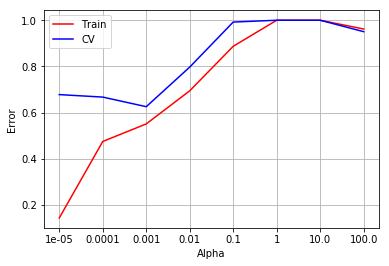

In [6]:
#Plot for Train & CV scores vs alpha_range
lines = plt.plot(range(0,8),(1-model.cv_results_['mean_train_score']), \
                 range(0,8),(1-model.cv_results_['mean_test_score']))

plt.setp(lines[0], color='r', label='Train')
plt.setp(lines[1], 'color', 'b', label='CV')

plt.xlabel('Alpha')
plt.ylabel('Error')
plt.xticks(range(0,8),alpha_range)
plt.legend()
plt.grid()

In [52]:
model.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [33]:
predictions = model.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.12125
Hamming loss  0.0039402
Micro-average quality numbers
Precision: 0.4616, Recall: 0.3094, F1-measure: 0.3705
Macro-average quality numbers
Precision: 0.3225, Recall: 0.2334, F1-measure: 0.2451


In [33]:
joblib.dump(model, 'bow_grid_lr_with_more_title_weight.pkl')

['bow_grid_lr_with_more_title_weight.pkl']

- Micro F1-measure: 0.3705
- Macro  F1-measure: 0.2451

**Micro & Macro F1 scores are higher than the previous model of SGDClassifier without tolerance with Hyperparam tuning. However it is lower than Logistic Regression model. Let's go for Hyper param tuning with tolerance set now**

**With max_iter=1000, tol=0.0001**

In [43]:
#With max_iter=1000, tol=0.0001
start = datetime.now()
alpha_range = [1e-5,1e-4,1e-3, 1e-2, 1e-1,1, 1e+1, 1e+2]
param_grid = {'estimator__alpha':alpha_range}
clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', max_iter=1000, tol=0.0001))
model = GridSearchCV(clf,param_grid=param_grid, scoring='f1_micro')
model.fit(x_train_multilabel, y_train)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 22:09:31.258898


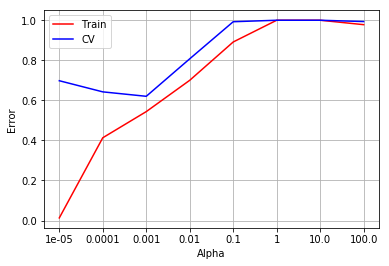

In [9]:
#Plot for Train & CV scores vs alpha_range
lines = plt.plot(range(0,8),(1-model.cv_results_['mean_train_score']), \
                 range(0,8),(1-model.cv_results_['mean_test_score']))

plt.setp(lines[0], color='r', label='Train')
plt.setp(lines[1], 'color', 'b', label='CV')

plt.xlabel('Alpha')
plt.ylabel('Error')
plt.xticks(range(0,8),alpha_range)
plt.legend()
plt.grid()

In [44]:
model.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [35]:
predictions = model.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.1434
Hamming loss  0.0035128
Micro-average quality numbers
Precision: 0.5680, Recall: 0.2612, F1-measure: 0.3579
Macro-average quality numbers
Precision: 0.3652, Recall: 0.2160, F1-measure: 0.2491


- Micro F1-measure: 0.3579
- Macro  F1-measure: 0.2491

**Micro & Macro F1 scores didn't improve as expected and it is lower than Logistic Regression model too.**

In [46]:
joblib.dump(model, 'bow_grid_lr_with_more_title_weight_tol.pkl')

['bow_grid_lr_with_more_title_weight_tol.pkl']

## OneVsRestClassifier with Linear-SVM (SGDClassifier with loss-hinge)

**Grid Search for Linear-SVM**

In [18]:
start = datetime.now()
alpha_range = [1e-5,1e-4,1e-3, 1e-2, 1e-1,1, 1e+1, 1e+2]
param_grid = {'estimator__alpha':alpha_range}
clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))
model = GridSearchCV(clf,param_grid=param_grid, scoring='f1_micro')
model.fit(x_train_multilabel, y_train)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 2:30:00.456055


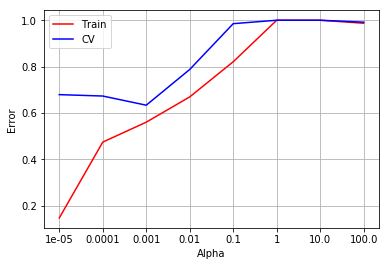

In [12]:
#Plot for Train & CV scores vs alpha_range
lines = plt.plot(range(0,8),(1-model.cv_results_['mean_train_score']), \
                 range(0,8),(1-model.cv_results_['mean_test_score']))

plt.setp(lines[0], color='r', label='Train')
plt.setp(lines[1], 'color', 'b', label='CV')

plt.xlabel('Alpha')
plt.ylabel('Error')
plt.xticks(range(0,8),alpha_range)
plt.legend()
plt.grid()

In [19]:
model.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [37]:
predictions = model.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.10905
Hamming loss  0.0040597
Micro-average quality numbers
Precision: 0.4355, Recall: 0.2817, F1-measure: 0.3421
Macro-average quality numbers
Precision: 0.2711, Recall: 0.2172, F1-measure: 0.2117


- Micro F1-measure: 0.3421
- Macro  F1-measure: 0.2117

**Let's fine tune with tolerance set and check if scores improve.**

In [22]:
joblib.dump(model, 'bow_grid_linearsvm_with_more_title_weight.pkl')

['bow_grid_linearsvm_with_more_title_weight.pkl']

**Fine tune Linear-SVM for alpha = 0.001 using tolerance = 0.0001**

In [47]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1', max_iter=1000, tol=0.0001 ))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 1:24:06.281366


In [39]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("==="*30)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("==="*30)

#print(metrics.classification_report(y_test, predictions))

Accuracy : 0.14115
Hamming loss  0.003537
Micro-average quality numbers
Precision: 0.5641, Recall: 0.2470, F1-measure: 0.3435
Macro-average quality numbers
Precision: 0.2767, Recall: 0.1948, F1-measure: 0.2063


- Micro F1-measure: 0.3435
- Macro  F1-measure: 0.2063

**With tolerance set to 0.0001 Micro F1 score increased marginally**

In [49]:
joblib.dump(classifier, 'bow_linearsvm_with_more_title_weight_tol.pkl')

['bow_linearsvm_with_more_title_weight_tol.pkl']

## Summary of Results obtained: 

In [51]:
x = PrettyTable()

x.field_names = ["Method", "Alpha", "tolerance", "F1 Micro", "F1 Macro"]

x.add_row(["Logistic Regression","NA","0.0001", "0.4443", "0.3297"])
x.add_row(["Logistic Reg (SGD Log Loss)","Default","NA", "0.3270", "0.2438"])
x.add_row(["Logistic Reg (SGD Log Loss)","Default","0.0001", "0.3766", "0.2779"])
x.add_row(["Logistic Reg(SGD Log Loss Hyper)","0.001","NA", "0.3705", "0.2451"])
x.add_row(["Logistic Reg(SGD Log Loss Hyper)","0.001","0.0001", "0.3579", "0.2491"])
x.add_row(["Linear SVM(SGD Hinge Loss Hyper)","0.001","NA","0.3421", "0.2117"])
x.add_row(["Linear SVM(SGD Hinge Loss Hyper)","0.001","0.0001", "0.3435", "0.2063"])


print("Summary of Optimal Results")
print(x)

print("\n Best Model among SGDClassifiers")
x = PrettyTable()

x.field_names = ["Method", "Alpha", "tolerance", "F1 Micro", "F1 Macro"]
x.add_row(["Logistic Reg (SGD Log Loss)","Default","0.0001", "0.3766", "0.2779"])
print(x)

Summary of Optimal Results
+----------------------------------+---------+-----------+----------+----------+
|              Method              |  Alpha  | tolerance | F1 Micro | F1 Macro |
+----------------------------------+---------+-----------+----------+----------+
|       Logistic Regression        |    NA   |   0.0001  |  0.4443  |  0.3297  |
|   Logistic Reg (SGD Log Loss)    | Default |     NA    |  0.3270  |  0.2438  |
|   Logistic Reg (SGD Log Loss)    | Default |   0.0001  |  0.3766  |  0.2779  |
| Logistic Reg(SGD Log Loss Hyper) |  0.001  |     NA    |  0.3705  |  0.2451  |
| Logistic Reg(SGD Log Loss Hyper) |  0.001  |   0.0001  |  0.3579  |  0.2491  |
| Linear SVM(SGD Hinge Loss Hyper) |  0.001  |     NA    |  0.3421  |  0.2117  |
| Linear SVM(SGD Hinge Loss Hyper) |  0.001  |   0.0001  |  0.3435  |  0.2063  |
+----------------------------------+---------+-----------+----------+----------+

 Best Model among SGDClassifiers
+-----------------------------+---------+-------

# Conclusion: 

1. Logistic Regression model outperformed all the other models with F1 micro score of 0.4443.
2. But since it's computationally expensive, SGDClassifier with Log loss was used which didn't match it's performance.
3. Also for Linear SVM, SGDClassifier with Hinge Loss was used.
4. Tolerance value of 0.0001 was chosen since it's the default value present in SKLearn's implementation of both Logistic Regression and Linear SVM.
5. Among the SGDClassifiers, simple SGD Log loss model (Logistic Regression) with tolerance set was slightly better than hypertuned model without tolerance set.
6. Perhaps simple model for SGD Log loss performed slightly better than hypertuned model due to small dataset.